# Bruk av geopandas med data fra NVDB og SSB

Demo av hvordan geopandas kan brukes med data fra [Nasjonal vegdatabank](https://www.vegvesen.no/fag/teknologi/Nasjonal+vegdatabank) (NVDB) og [Statistisk Sentralbyrå](http://www.ssb.no/natur-og-miljo/geodata) (SSB). 

Vi ønsker å finne hvilke turistveger som går gjennom hvilke tettsteder - og hvilke trafikkulykker som er registrert der. 

Gangen er som følger: 
1. Last ned data over tettsteder fra [SSB](http://www.ssb.no/natur-og-miljo/geodata
1. Last ned turistveger fra [NVDB api](https://www.vegvesen.no/nvdb/apidokumentasjon/)
1. Finn snittet av turistveger og tettsteder (hvilke turistveger som går gjennom hvilke tettsteder)
1. Last ned trafikkulykker på turistvegene  
    1. Vi bruker NVDB api'ets [overlappfilter](https://www.vegvesen.no/nvdb/apidokumentasjon/#/parameter/overlappfilter)
1. Finn snittet av trafikkulykker på turistveger og tettsteder på turistveger
    1. Strengt tatt kunne vi nøyd oss med snittet av ulykker på turistveger og tettsteder - men med valgt metodikk får vi med egenskapene til turistveger også. 

# Installasjon 

[installasjon](installasjon.md) 

# Last ned data fra SSB

Dette steget kan også gjøres manuelt. Direkte lenke for nedlasting av 2016-datasett er http://www.ssb.no/natur-og-miljo/_attachment/286736?_ts=158d3354ee0 

*NB! Det vil ikke overraske meg om lenkeråte gjør at du uansett må inn på SSB og finne nedlastingslenker* 

### Hent SSB-data manuelt 

1. Gå inn på http://www.ssb.no/natur-og-miljo/geodata#Nedlasting_av_datasett_med_dynamiske_avgrensinger . 
1. Klikk på *Nedlasting av kart over tettsteder*. 
1. Klikk på det året du vil laste ned for. 
    1. Nedlasting skal starte automagisk... hvis ikke kan du prøve en annen nettleser, evt kopiere lenken og bruke verktøy som curl eller wget. 
1. Pakk ut zip-arkivet og legg mappen ```Tettsted2016``` sammen med øvrige filer (rotnivå i repos'et). Dvs at stien til shapefilen skal være ```Tettsted2016/Tettsted2016.shp```







In [24]:
## Last ned SSB-data
# Se https://stackoverflow.com/a/14260592 , det om python 3+
import requests
import zipfile
import io
import os

url = 'http://www.ssb.no/natur-og-miljo/_attachment/286736?_ts=158d3354ee0'

# Laster kun en gang: 
if not os.path.exists('Tettsted2016/Tettsted2016.shp'):
    r = requests.get(url)
    if r.ok: 
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
    else: 
        print( "Nedlasting feiler:", r.status_code, r.reason )
        

# Importer de bibliotekene som trengs


In [4]:
import geopandas as gpd
import pandas as pd
import nvdbapi      # Fra https://github.com/LtGlahn/nvdbapi-V2
import nvdb2geojson # Fra https://github.com/LtGlahn/nvdbapi-V2

# Les data

In [5]:
tettsted = gpd.read_file( 'Tettsted2016/Tettsted2016.shp')
turistveger = nvdbapi.nvdbFagdata(777)
turistveger_geojson = nvdb2geojson.fagdata2geojson( turistveger)

C:\Data\test\notebook\geopandas_vegdata_eksempel\nvdbapi.py:293: UserWarning: 
You should provide the file nvdbapi-clientinfo.json 
 
{ "X-Client" : "YOUR SYSTEM",
 "X-Kontaktperson" : "ola.nordmann@eposten.din" }

  warn( mytext )


In [6]:
turist2 = gpd.GeoDataFrame.from_features( turistveger_geojson['features'])

# Finn turistveger i tettsteder 

http://geopandas.org/mergingdata.html , spatial joins. 



In [7]:
tettsted.crs = {'init': 'epsg:25833'}
turist2.crs = {'init': 'epsg:25833'}

turist_i_tettsted = gpd.sjoin( turist2, tettsted, how='inner', op='intersects')
tettsted_m_turist = gpd.sjoin( tettsted, turist2, how='inner', op='intersects')


C:\Users\jajens\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2652: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [8]:
print( "Antall segmenter med turistveger", len( turist2))
print( "Antall tettsteder", len(tettsted))
print( "Tettsteder med turistveger", len(tettsted_m_turist), "FJERN DUPLIKATER?")
print( "Turistveger som går gjennom tettsteder", len(turist_i_tettsted))

Antall segmenter med turistveger 527
Antall tettsteder 990
Tettsteder med turistveger 120 FJERN DUPLIKATER?
Turistveger som går gjennom tettsteder 120


Våre 17 turistveger er splittet opp i 527 korte segmenter - og overgangen mellom segmentene er ofte i vegkryss, dvs vi har typisk mer enn ett turistveg-segment per tettsted. Det gir duplikater som må fjernes fra datasettet _tettsteder med turistveger_

In [9]:
tettsted_m_turist.drop_duplicates( subset='TETTNR', inplace=True)
print( "Tettsteder med turistveger", len(tettsted_m_turist), "UTEN duplikater")

Tettsteder med turistveger 44 UTEN duplikater


# Finner trafikkulykker på turistveger

Bruker NVDB api's overlappfilter https://www.vegvesen.no/nvdb/apidokumentasjon/#/parameter/overlappfilter 


In [12]:
ulykker = nvdbapi.nvdbFagdata( 570)
ulykker.addfilter_overlapp( '777'  )
print( 'Antall ulykker på turistveger', ulykker.statistikk()) 

C:\Data\test\notebook\geopandas_vegdata_eksempel\nvdbapi.py:293: UserWarning: 
You should provide the file nvdbapi-clientinfo.json 
 
{ "X-Client" : "YOUR SYSTEM",
 "X-Kontaktperson" : "ola.nordmann@eposten.din" }

  warn( mytext )


Antall ulykker på turistveger {'antall': 4076, 'strekningslengde': 0}


### Gjør om ulykkene til geodataframe

In [23]:
ulykker_geojson = nvdb2geojson.fagdata2geojson( ulykker)
ulykker_gpd = gpd.GeoDataFrame.from_features( ulykker_geojson['features']);


### Hvor mange av disse trafikkulykkene er i tettsteder? 

In [14]:
ulykker_gpd.crs = {'init': 'epsg:25833'}
# Spatial join gir kolonnene 'index_right' og 'index_left'. Disse må slettes eller døpes om 
# før resultatet fra spatial join brukes i nye joins
tettsted_m_turist.rename( columns={ 'index_right' : 'tettsted_m_turist_indeks_right'}, inplace=True)
ulykker_i_tettsted = gpd.sjoin( ulykker_gpd, tettsted_m_turist, how='inner', op='intersects')
ulykker_i_tettsted.shape

(649, 78)

In [16]:
ulykker_i_tettsted.columns

Index(['Alvorligste skadegrad', 'Antall alvorlig skadet',
       'Antall drepte i ulykken', 'Antall enheter', 'Antall kjørefelt',
       'Antall lettere skadet', 'Antall meget alvorlig skadet', 'Bebyggelse',
       'Dekketype', 'Fartsgrense', 'Felttype', 'Forsterket vegoppmerking',
       'Føreforhold', 'Geometri, punkt', 'Historisk hp',
       'Historisk kilometerverdi', 'Historisk vegkategori',
       'Historisk vegnummer', 'Historisk vegstatus', 'Kommunenr', 'Lysforhold',
       'Midtdeler', 'Registreringsdato for fagdata',
       'Stedfestingens nøyaktighet', 'Stedsforhold', 'Temperatur',
       'Uhell kategori', 'Uhellskode', 'Ukedag', 'Ulykkesdato',
       'Ulykkestidspunkt', 'Vegbredde', 'Vegnavn', 'Vegtype', 'Værforhold',
       'antall vegsegmenter_left', 'fylke_left', 'geometry', 'hp_left',
       'id_left', 'kategori_left', 'kommune_left', 'kortform_left',
       'metadata_left', 'meter', 'nummer_left', 'region_left', 'status_left',
       'stedfesting_left', 'vegavdeling_le

In [17]:
%matplotlib inline
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

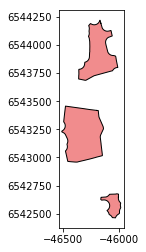

In [18]:
tettsted_m_turist[ tettsted_m_turist.TETTNR == '4578'].geometry.plot()


In [19]:
ulykker_i_tettsted.geometry.head()

8               POINT Z (89272.83984 6831871.18994 2.98)
98           POINT Z (89542.36386 6831112.47493 2.52845)
112    POINT Z (89322.36126000001 6831828.35874 2.85016)
137           POINT Z (89373.62676 6831765.62907 2.8322)
138          POINT Z (89435.66747 6831494.08702 3.49889)
Name: geometry, dtype: object

In [20]:
# Dumper til fil: 

with open('ulykker.json', 'w') as f:
    f.write(ulykker_gpd.to_json())
    
with open('tettsted_m_turist.json', 'w') as f:
    f.write(tettsted_m_turist.to_json())

In [21]:
with open('ulykker_litenJoin.geojson', 'w') as f:
    f.write(junk.to_json())
    
with open('ulykker_storJoin.geojson', 'w') as f:
    f.write(ulykker_i_tettsted.to_json())

In [22]:
# fjerner duplikater? 
tettsted_m_turist[ tettsted_m_turist.Tettstedsn == 'Tyssedal' ]

,Areal_km2,Beff_tett,TETTNR,Tettstedsn,Tot_Bef,geometry,tettsted_m_turist_indeks_right,Link turistveg,Navn,Status,...,kortform,metadata,nummer,region,status,stedfesting,strekningslengde,til_meter,vegavdeling,vegsegment nr
404,0.623732,994.016865,5093,Tyssedal,620,"POLYGON ((31611.71229999978 6695084.5956, 3161...",429,http://www.nasjonaleturistveger.no/no/hardanger,Hardanger,Nasjonal turistveg,...,1200 Rv13 hp5 m0-4944,"{'type': {'id': 777, 'navn': 'Turistveg'}, 've...",13,3,V,"{'veglenkeid': 805649, 'fra_posisjon': 0.0, 't...",4944,4944,12,67
